# Градиентный бустинг своими руками

**Внимание:** в тексте задания произошли изменения - поменялось число деревьев (теперь 50), правило изменения величины шага в задании 3 и добавился параметр `random_state` у решающего дерева. Правильные ответы не поменялись, но теперь их проще получить. Также исправлена опечатка в функции `gbm_predict`.

В этом задании будет использоваться датасет `boston` из `sklearn.datasets`. Оставьте последние 25% объектов для контроля качества, разделив `X` и `y` на `X_train`, `y_train` и `X_test`, `y_test`.

Целью задания будет реализовать простой вариант градиентного бустинга над регрессионными деревьями для случая квадратичной функции потерь.

In [1]:
from sklearn import model_selection, datasets, tree, metrics, linear_model
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dataset = datasets.load_boston()

In [3]:
#X_train, X_test, y_train, y_test = model_selection.train_test_split(
#                                        dataset['data'],
#                                        dataset['target'],
#                                        test_size=0.25
#                                    )
p = 0.75

idx = int(p * dataset.data.shape[0]) + 1

X_train, X_test = np.split(dataset.data, [idx])
y_train, y_test = np.split(dataset.target, [idx])

In [4]:
X_train.shape, y_train.shape

((380, 13), (380,))

## Задание 1

Как вы уже знаете из лекций, **бустинг** - это метод построения композиций базовых алгоритмов с помощью последовательного добавления к текущей композиции нового алгоритма с некоторым коэффициентом. 

Градиентный бустинг обучает каждый новый алгоритм так, чтобы он приближал антиградиент ошибки по ответам композиции на обучающей выборке. Аналогично минимизации функций методом градиентного спуска, в градиентном бустинге мы подправляем композицию, изменяя алгоритм в направлении антиградиента ошибки.

Воспользуйтесь формулой из лекций, задающей ответы на обучающей выборке, на которые нужно обучать новый алгоритм (фактически это лишь чуть более подробно расписанный градиент от ошибки), и получите частный ее случай, если функция потерь `L` - квадрат отклонения ответа композиции `a(x)` от правильного ответа `y` на данном `x`.

Если вы давно не считали производную самостоятельно, вам поможет таблица производных элементарных функций (которую несложно найти в интернете) и правило дифференцирования сложной функции. После дифференцирования квадрата у вас возникнет множитель 2 — т.к. нам все равно предстоит выбирать коэффициент, с которым будет добавлен новый базовый алгоритм, проигноируйте этот множитель при дальнейшем построении алгоритма.

In [5]:
def derivative_L(y_train, z):
    return (y_train - z)

## Задание 2

Заведите массив для объектов `DecisionTreeRegressor` (будем их использовать в качестве базовых алгоритмов) и для вещественных чисел (это будут коэффициенты перед базовыми алгоритмами). 

В цикле от обучите последовательно 50 решающих деревьев с параметрами `max_depth=5` и `random_state=42` (остальные параметры - по умолчанию). В бустинге зачастую используются сотни и тысячи деревьев, но мы ограничимся 50, чтобы алгоритм работал быстрее, и его было проще отлаживать (т.к. цель задания разобраться, как работает метод). Каждое дерево должно обучаться на одном и том же множестве объектов, но ответы, которые учится прогнозировать дерево, будут меняться в соответствие с полученным в задании 1 правилом. 

Попробуйте для начала всегда брать коэффициент равным 0.9. Обычно оправдано выбирать коэффициент значительно меньшим - порядка 0.05 или 0.1, но т.к. в нашем учебном примере на стандартном датасете будет всего 50 деревьев, возьмем для начала шаг побольше.

В процессе реализации обучения вам потребуется функция, которая будет вычислять прогноз построенной на данный момент композиции деревьев на выборке `X`:

```
def gbm_predict(X):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, coefficients_list)]) for x in X]
(считаем, что base_algorithms_list - список с базовыми алгоритмами, coefficients_list - список с коэффициентами перед алгоритмами)
```

Эта же функция поможет вам получить прогноз на контрольной выборке и оценить качество работы вашего алгоритма с помощью `mean_squared_error` в `sklearn.metrics`. 

Возведите результат в степень 0.5, чтобы получить `RMSE`. Полученное значение `RMSE` — **ответ в пункте 2**.

In [6]:
def gbm_predict(X):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, coefficients_list)]) for x in X]

In [7]:
base_algorithms_list = []
coefficients_list = []

In [8]:
z = np.zeros((y_train.shape))
for _ in range(50):
    coefficients_list.append(0.9)
    curr_reg = tree.DecisionTreeRegressor(max_depth=5, random_state=42)
    curr_reg.fit(X_train, derivative_L(y_train, z))
    base_algorithms_list.append(curr_reg)
    z = gbm_predict(X_train)
alg_predict = gbm_predict(X_test)
alg_rmse = np.sqrt(metrics.mean_squared_error(y_test, alg_predict))

In [9]:
print(alg_rmse)

5.455221764927308


In [10]:
with open('answer2.txt', 'w') as f:
    f.write(str(alg_rmse))

## Задание 3

Вас может также беспокоить, что двигаясь с постоянным шагом, вблизи минимума ошибки ответы на обучающей выборке меняются слишком резко, перескакивая через минимум. 

Попробуйте уменьшать вес перед каждым алгоритмом с каждой следующей итерацией по формуле `0.9 / (1.0 + i)`, где `i` - номер итерации (от 0 до 49). Используйте качество работы алгоритма как **ответ в пункте 3**. 

В реальности часто применяется следующая стратегия выбора шага: как только выбран алгоритм, подберем коэффициент перед ним численным методом оптимизации таким образом, чтобы отклонение от правильных ответов было минимальным. Мы не будем предлагать вам реализовать это для выполнения задания, но рекомендуем попробовать разобраться с такой стратегией и реализовать ее при случае для себя.

In [11]:
base_algorithms_list = []
coefficients_list = []

In [12]:
z = np.zeros((y_train.shape))
for i in range(50):
    coefficients_list.append(0.9/(1.0+i))
    curr_reg = tree.DecisionTreeRegressor(max_depth=5, random_state=42)
    curr_reg.fit(X_train, derivative_L(y_train, z))
    base_algorithms_list.append(curr_reg)
    z = gbm_predict(X_train)
alg_predict = gbm_predict(X_test)
alg_rmse = np.sqrt(metrics.mean_squared_error(y_test, alg_predict))

In [13]:
print(alg_rmse)

5.241033584774468


In [14]:
with open('answer3.txt', 'w') as f:
    f.write(str(alg_rmse))

## Задание 4

Реализованный вами метод - градиентный бустинг над деревьями - очень популярен в машинном обучении. Он представлен как в самой библиотеке `sklearn`, так и в сторонней библиотеке `XGBoost`, которая имеет свой питоновский интерфейс. На практике `XGBoost` работает заметно лучше `GradientBoostingRegressor` из `sklearn`, но для этого задания вы можете использовать любую реализацию. 

Исследуйте, переобучается ли градиентный бустинг с ростом числа итераций (и подумайте, почему), а также с ростом глубины деревьев. На основе наблюдений выпишите через пробел номера правильных из приведенных ниже утверждений в порядке возрастания номера (это будет **ответ в п.4**):

    1. С увеличением числа деревьев, начиная с некоторого момента, качество работы градиентного бустинга не меняется существенно.

    2. С увеличением числа деревьев, начиная с некоторого момента, градиентный бустинг начинает переобучаться.

    3. С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга на тестовой выборке начинает ухудшаться.

    4. С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга перестает существенно изменяться

### 4.1 Зависимость градиентного бустинга от числа итераций (числа деревьей)

In [15]:
n_iter = np.arange(50, 1550, 100)
scores_1 = np.zeros(n_iter.size)

In [16]:
for i in range(n_iter.size):
    estimator = xgb.XGBRegressor(n_estimators=n_iter[i])
    estimator.fit(X_train, y_train)
    alg_predict = estimator.predict(X_test)
    scores_1[i] = np.sqrt(metrics.mean_squared_error(y_test, alg_predict))

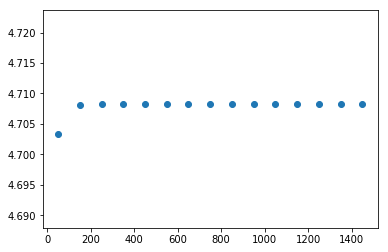

In [17]:
plt.scatter(n_iter, scores_1)

### 4.2 Зависимость градиентного бустинга от глубины деревьев

In [18]:
depths = np.arange(1, 13, 1)
scores_2 = np.zeros(depths.size)

In [19]:
for i in range(depths.size):
    estimator = xgb.XGBRegressor(max_depth=depths[i])
    estimator.fit(X_train, y_train)
    alg_predict = estimator.predict(X_test)
    scores_2[i] = np.sqrt(metrics.mean_squared_error(y_test, alg_predict))

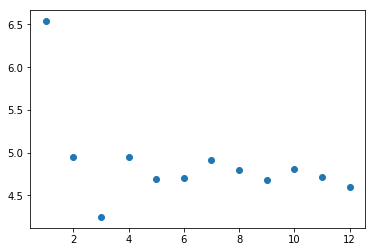

In [20]:
plt.scatter(depths, scores_2)

In [21]:
with open('answer4.txt', 'w') as f:
    f.write('2 3')

## Задание 5

Сравните получаемое с помощью градиентного бустинга качество с качеством работы линейной регрессии. 

Для этого обучите `LinearRegression` из `sklearn.linear_model` (с параметрами по умолчанию) на обучающей выборке и оцените для прогнозов полученного алгоритма на тестовой выборке `RMSE`. Полученное качество - ответ в **пункте 5**. 

В данном примере качество работы простой модели должно было оказаться хуже, но не стоит забывать, что так бывает не всегда. В заданиях к этому курсу вы еще встретите пример обратной ситуации.

In [22]:
l_r = linear_model.LinearRegression()
l_r.fit(X_train, y_train)

LinearRegression()

In [23]:
rmse_5 = np.sqrt(metrics.mean_squared_error(y_test, l_r.predict(X_test)))

In [24]:
print(rmse_5)

7.819688142087171


In [25]:
with open('answer5.txt', 'w') as f:
    f.write(str(rmse_5))